In [1]:
#Insurance cost prediction using linear regression

In [2]:
# Uncomment and run the commands below if imports fail
#!conda install numpy pytorch torchvision cpuonly -c pytorch -y
#!pip install pandas --upgrade --quiet
#!pip install matplotlib --upgrade --quiet
#!pip install matplotlib seaborn --upgrade --quiet

In [3]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

#!conda install numpy pytorch torchvision cpuonly -c pytorch -y

In [4]:
#Step 1: Download and explore the data
#Let us begin by downloading the data. We'll use the download_url function from PyTorch to get the data as a CSV (comma-separated values) file.

In [5]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

#To load the dataset into memory, we'll use the read_csv function from the pandas library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

Using downloaded and verified file: .\insurance.csv


In [6]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

#We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
your_name = "Todor" # at least 5 characters

#The customize_dataset function will customize the dataset slightly using your name as a source of random numbers.

In [8]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [9]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
647,40,female,25.9407,3,no,8252.28430
1272,43,male,28.3272,5,no,14478.33015
880,22,male,38.6280,3,no,3443.06400
957,24,male,29.7369,1,no,12609.88702
1209,59,male,41.1810,1,no,12347.17200


In [10]:
#Let us answer some basic questions about the dataset.


In [11]:
#Q: How many rows does the dataset have?

num_rows = dataframe.shape[0]
print(num_rows)

1271


In [12]:
#Q: How many columns doe the dataset have
    
num_cols = dataframe.shape[1]
print(num_cols)  

6


In [13]:
#Q: What are the column titles of the input variables? Hint: sex is one of them. List the columns that are not numbers.

input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']

# a little fix of the code

input_cols = dataframe.columns[:5].tolist()
categorical_cols = dataframe.select_dtypes(exclude='number').columns.tolist()


In [14]:
#Q: What are the column titles of output/target variable(s)?

output_cols = ['charges']

1121.8739
63770.42801


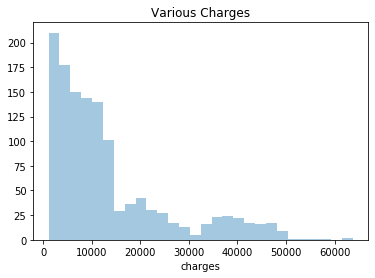

In [15]:
print(dataframe['charges'].min())
print(dataframe['charges'].max())


import seaborn as sns

plt.title("Various Charges")
sns.distplot(dataframe.charges, kde=False);

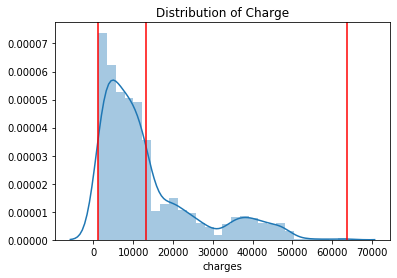

In [16]:
#Q: (Optional) What is the minimum, maximum and average value of the charges column? Can you show the distribution of values in a graph? Use this data visualization cheatsheet

plt.title("Distribution of Charge")

sns.distplot(dataframe.charges)
plt.axvline(x=dataframe['charges'].min(),color="red")
plt.axvline(x=dataframe['charges'].max(),color="red")
plt.axvline(x=dataframe['charges'].mean(),color="red")

In [17]:
#Step 2: Prepare the dataset for training

In [18]:
#We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out input_cols, categorial_cols and output_cols correctly, this following function will perform the conversion to numpy arrays.

In [19]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [20]:
#Read through the Pandas documentation to understand how we're converting categorical variables into numbers.

In [21]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[40.    ,  0.    , 25.9407,  3.    ,  0.    ],
        [43.    ,  1.    , 28.3272,  5.    ,  0.    ],
        [22.    ,  1.    , 38.628 ,  3.    ,  0.    ],
        ...,
        [24.    ,  1.    , 25.974 ,  0.    ,  0.    ],
        [39.    ,  0.    , 46.398 ,  0.    ,  0.    ],
        [58.    ,  1.    , 42.18  ,  0.    ,  0.    ]]),
 array([[ 8252.2843 ],
        [14478.33015],
        [ 3443.064  ],
        ...,
        [ 1969.614  ],
        [ 5662.225  ],
        [11365.952  ]]))

In [23]:
#Q: Convert the numpy arrays inputs_array and targets_array into PyTorch tensors. Make sure that the data type is torch.float32.

inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)
inputs, targets

(tensor([[40.0000,  0.0000, 25.9407,  3.0000,  0.0000],
         [43.0000,  1.0000, 28.3272,  5.0000,  0.0000],
         [22.0000,  1.0000, 38.6280,  3.0000,  0.0000],
         ...,
         [24.0000,  1.0000, 25.9740,  0.0000,  0.0000],
         [39.0000,  0.0000, 46.3980,  0.0000,  0.0000],
         [58.0000,  1.0000, 42.1800,  0.0000,  0.0000]]),
 tensor([[ 8252.2842],
         [14478.3301],
         [ 3443.0640],
         ...,
         [ 1969.6140],
         [ 5662.2251],
         [11365.9521]]))

In [24]:
inputs.dtype, targets.dtype


(torch.float32, torch.float32)

In [25]:
#Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a TensorDataset.

In [26]:
dataset = TensorDataset(inputs, targets)


In [27]:
#**Q: Pick a number between 0.1 and 0.2 to determine the fraction of data that will be used for creating the validation set. Then use random_split to create training & validation datasets. **

In [28]:
val_percent = 0.18 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) 
# Use the random_split function to split dataset into 2 parts of the desired length

#Finally, we can create data loaders for training & validation.


In [29]:
#Q: Pick a batch size for the data loader.


In [30]:
batch_size = 25


In [31]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [32]:
#Let's look at a batch of data to verify everything is working fine so far.


In [33]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[19.0000,  0.0000, 30.9690,  0.0000,  1.0000],
        [32.0000,  1.0000, 41.2698,  2.0000,  0.0000],
        [22.0000,  1.0000, 41.1477,  2.0000,  1.0000],
        [19.0000,  0.0000, 22.8660,  0.0000,  0.0000],
        [43.0000,  0.0000, 29.6370,  2.0000,  1.0000],
        [45.0000,  1.0000, 33.6996,  0.0000,  1.0000],
        [43.0000,  1.0000, 33.4277,  3.0000,  0.0000],
        [24.0000,  1.0000, 37.3293,  4.0000,  0.0000],
        [60.0000,  1.0000, 45.4212,  0.0000,  1.0000],
        [50.0000,  0.0000, 30.6360,  1.0000,  1.0000],
        [55.0000,  0.0000, 29.9478,  0.0000,  0.0000],
        [62.0000,  1.0000, 41.5140,  0.0000,  0.0000],
        [53.0000,  0.0000, 39.8490,  2.0000,  0.0000],
        [43.0000,  1.0000, 36.1860,  2.0000,  0.0000],
        [33.0000,  1.0000, 39.6825,  2.0000,  0.0000],
        [36.0000,  0.0000, 28.7490,  1.0000,  0.0000],
        [62.0000,  0.0000, 29.1819,  0.0000,  1.0000],
        [60.0000,  0.0000, 39.9655,  0.0000,  0.0000],
  

In [34]:
#Step 3: Create a Linear Regression Model


In [35]:
#Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment).


In [36]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(5, 1)

In [37]:
#Q: Complete the class definition below by filling out the constructor (__init__), forward, training_step and validation_step methods.

#Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [38]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss (out, targets)                          # fill this
        # mse_loss works best when the data is normalized. since this is skewed, use l1_loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss (out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [39]:
#Let us create a model using the InsuranceModel class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes nan or infinity.


In [40]:
model = InsuranceModel()


In [41]:
#Let's check out the weights and biases of the model using model.parameters.


In [42]:
list(model.parameters())


[Parameter containing:
 tensor([[-0.2825,  0.1029,  0.0638,  0.1964,  0.1095]], requires_grad=True),
 Parameter containing:
 tensor([0.0603], requires_grad=True)]

In [43]:
#Step 4: Train the model to fit the data


In [44]:
#To train our model, we'll use the same fit function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.


In [45]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [46]:
#Q: Use the evaluate function to calculate the loss on the validation set before training.


In [47]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13869.455078125}


In [48]:
#We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or nan), you may have to re-initialize the model by running the cell model = InsuranceModel(). Experiment with this for a while, and try to get to as low a loss as possible.


In [49]:
#Q: Train the model 4-5 times with different learning rates & for different number of epochs.

#Hint: Vary learning rates by orders of 10 (e.g. 1e-2, 1e-3, 1e-4, 1e-5, 1e-6) to figure out what works.


In [50]:
epochs = 100
lr = 1e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7386.9556
Epoch [40], val_loss: 7331.1343
Epoch [60], val_loss: 7312.6187
Epoch [80], val_loss: 7309.1509
Epoch [100], val_loss: 7292.7788


In [51]:
epochs = 40
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7300.7422
Epoch [40], val_loss: 7300.5610


In [52]:
epochs = 50
lr = 1e-1
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7285.6030
Epoch [40], val_loss: 7277.7529
Epoch [50], val_loss: 7300.1313


In [53]:
epochs = 50
lr = 1e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7278.1470
Epoch [40], val_loss: 7277.5186
Epoch [50], val_loss: 7278.1733


In [54]:
epochs = 50
lr = 1e-3
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7277.7471
Epoch [40], val_loss: 7277.1641
Epoch [50], val_loss: 7277.0015


In [55]:
#Q: What is the final validation loss of your model?


In [56]:
val_loss = history5[-1]['val_loss']
val_loss

7277.00146484375

In [57]:
#Step 5: Make predictions using the trained model


In [58]:
#Q: Complete the following function definition to make predictions on a single input


In [59]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [60]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([18.0000,  0.0000, 24.0426,  0.0000,  1.0000])
Target: tensor([14283.4590])
Prediction: tensor([2837.0754])


In [61]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([25.0000,  0.0000, 38.2784,  0.0000,  0.0000])
Target: tensor([3021.8091])
Prediction: tensor([3388.6289])


In [62]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([24.0000,  0.0000, 28.0497,  0.0000,  0.0000])
Target: tensor([3044.2134])
Prediction: tensor([3916.3716])
